<a href="https://colab.research.google.com/github/JuanSpecht/PDI2021/blob/main/TP7/PDI_TP7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PDI - Trabajo Práctico 7: Procesamiento morfológico

## Importo las bibliotecas necesarias

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import ipywidgets as widgets
import IPython.display as ipd
from google.colab import files

## BACKEND

In [8]:
def subtraction (img_1, img_2, mode):
    '''
    - img_1, img_2: imágenes a restar (se sustrae img_2 de img_1).
    - mode: modo de resta (clampeada o promediada).
    '''
    if mode == 'Clampeada':
        result = np.subtract(np.array(img_1), np.array(img_2), dtype=np.int32) 
        result = np.clip(result, 0, 255)
    if mode == 'Promediada':
        result = (np.subtract(np.array(img_1, dtype=np.int32), np.array(img_2, dtype=np.int32)) + 255) // 2
    return result

def apply_filter (input_img, filter, options):
    '''
    - input_img: imagen a filtrar.
    - filter: nombre del filtro a utilizar.
    - options: diccionario con dos claves: 'image type' y 'subtraction mode'.
    
        La erosión toma el menor valor alrededor del pixel así que paddeo con 255 
    para que el padding no influya en el resultado. La dilatación toma el máximo
    valor alrededor del pixel, entonces por lo mismo paddeo con 0. 
    '''
    if options['image type'] == 'Figura clara/fondo oscuro':
        func_erosion = np.amin
        func_dilatation = np.amax
        padding_erosion = 255
        padding_dilatation = 0
    elif options['image type'] == 'Figura oscura/fondo claro':
        func_erosion = np.amax
        func_dilatation = np.amin
        padding_erosion = 0
        padding_dilatation = 255

    if filter == 'Erosión' or filter == 'Dilatación':
        output_img = np.empty_like(input_img)
        if filter == 'Erosión':
            input_img = np.pad(input_img, 1, constant_values=padding_erosion)
        elif filter == 'Dilatación':
            input_img = np.pad(input_img, 1, constant_values=padding_dilatation)
        for i in range(np.shape(output_img)[0]):
            try:
                View.progress_bar.value = i/np.shape(output_img)[0]
                View.progress_bar.description = str(int(100 * i/np.shape(output_img)[0])) + ' %'
            except:
                pass
            for j in range(np.shape(output_img)[1]):
                if filter == 'Erosión':
                    output_img[i,j] = func_erosion(input_img[i:i+3, j:j+3])
                if filter == 'Dilatación':
                    output_img[i,j] = func_dilatation(input_img[i:i+3, j:j+3])
    elif filter == 'Apertura':
        output_img = apply_filter(apply_filter(input_img, 'Erosión', options), 'Dilatación', options)
    elif filter == 'Cierre':
        output_img = apply_filter(apply_filter(input_img, 'Dilatación', options), 'Erosión', options)
    elif filter == 'Borde Interior':
        output_img = subtraction(apply_filter(input_img, 'Dilatación', options), input_img, options['subtraction mode'])
    elif filter == 'Borde Exterior':
        output_img = subtraction(input_img, apply_filter(input_img, 'Erosión', options), options['subtraction mode'])
    elif filter == 'Top Hat':
        output_img = subtraction(input_img, apply_filter(input_img, 'Apertura', options), options['subtraction mode'])
    elif filter == 'Mediana':
        output_img = np.empty_like(input_img)
        '''paddeo con -1, ya que es seguro que ese valor no va a estar en la imagen
        original, y después considero sólo los píxeles con valor distinto a -1'''
        input_img = np.pad(input_img, 1, constant_values=-1)
        for i in range(np.shape(output_img)[0]):
            try:
                View.progress_bar.value = i/np.shape(output_img)[0]
                View.progress_bar.description = str(int(100 * i/np.shape(output_img)[0])) + ' %'
            except:
                pass
            for j in range(np.shape(output_img)[1]):
                array = input_img[i:i+3, j:j+3]
                output_img[i,j] = np.median(array[array != -1])
    
    return output_img

## FRONTEND

In [9]:
class MorphFilterUI:

    def __init__(self):
        # Creo la caja donde van los controles
        self.controls_box = widgets.VBox(layout=widgets.Layout(
            align_items='center',))

        self.par = dict()
        self.par['options'] = dict()

        self.initUI()

    def initUI(self):
        # Inicializo las funciones que manejan los widgets
        self.initImageTypeSelector()
        self.initFilterDropdown()
        self.initSubstractionModeSelector()
        self.initLoadButton()
        self.initCopyButton()
        self.initSaveButton() 
        self.initRunButton()
        self.initResetButton()
        self.initProgressBar()

        # Armo el layout de la interfaz
        self.controls = widgets.VBox([
            widgets.GridBox([self.load_button,
                             self.run_button,
                             self.save_button,
                             self.copy_button,
                             self.reset_button],
                            layout=widgets.Layout(grid_template_columns="1fr 1fr",
                                                  grid_template_rows="1fr 1fr")),
            self.controls_box,
            ],
            layout=widgets.Layout(align_items='stretch'))

        self.input_image = widgets.Output(layout=widgets.Layout(
            overflow_x='hidden',
            overflow_y='hidden',
            justify_content='center',
            align_items='center'))

        self.output_image = widgets.Output(layout=widgets.Layout(
            overflow_x='hidden',
            overflow_y='hidden',
            justify_content='center',
            align_items='center'))

        self.image_panel = widgets.VBox([widgets.HBox([self.input_image,
                                                       self.output_image]),
                                         self.progress_bar]
                                        )
        
        self.UI = widgets.HBox([self.controls,self.image_panel])

    def initLoadButton(self):
        self.load_button = widgets.FileUpload(
            accept='',
            multiple=False,
            description="Abrir"
            )
        
        self.load_button.observe(self.updateInputImage, 'value')
    
    def updateInputImage(self, change):
        self.par['input_image'] = np.array(Image.open(BytesIO(self.load_button.data[0])).convert('L'))
        
        with self.input_image:
            ipd.clear_output()
            fig, ax = plt.subplots(figsize=(7,7))
            plt.imshow(self.par['input_image'], cmap='gray', interpolation="nearest")
            plt.Axes(fig, [0,0,1,1])
            plt.axis('off')
            plt.show()

    def initCopyButton(self):
        self.copy_button = widgets.Button(
            description='Copiar salida'
        )

        self.copy_button.on_click(self.copyOutput)
    
    def copyOutput(self, change):
        self.par['input_image'] = self.par['output_image']

        with self.input_image:
            ipd.clear_output()
            fig, ax = plt.subplots(figsize=(7,7))
            plt.imshow(self.par['input_image'], cmap='gray', interpolation="nearest")
            plt.Axes(fig, [0,0,1,1])
            plt.axis('off')
            plt.show()

    def initRunButton(self):
        self.run_button = widgets.Button(description="Aplicar")
        self.run_button.on_click(self.updateOutputImage)
    
    def updateOutputImage(self, change):

        with self.output_image:
            ipd.clear_output()
            
        self.progress_bar.layout.visibility = 'visible'

        img = self.par['input_image']
        filter = self.par['filter']

        self.par['output_image'] = apply_filter(
            img,
            filter,
            self.par['options']
            )
        
        with self.output_image:
            fig, ax = plt.subplots(figsize=(7,7))
            plt.imshow(self.par['output_image'], 'gray', interpolation="nearest")
            plt.Axes(fig, [0,0,1,1])
            plt.axis('off')
            plt.show()
        
        self.progress_bar.layout.visibility = 'hidden'

    def initFilterDropdown(self):
        self.filter_dropdown = widgets.Dropdown(
            options=["Erosión",
                     "Dilatación",
                     "Apertura",
                     "Cierre",
                     "Borde Interior",
                     "Borde Exterior",
                     "Mediana",
                     "Top Hat"],
                     description='Filtro:', 
                    layout=widgets.Layout(width='max_content',),
                     continuous_update=True)
        
        self.filer_box = widgets.VBox([widgets.Label(value='Filtro:'),
                                             self.filter_dropdown],
                                            )
        
        self.updateFilter(None)

        self.filter_dropdown.observe(self.updateFilter, "value")

    def updateFilter(self, change):
        self.par['filter'] = self.filter_dropdown.value

        if self.par['filter'] == "Borde Interior" or \
        self.par['filter'] == "Borde Exterior" or \
        self.par['filter'] == "Top Hat":
            self.controls_box.children = [self.filter_dropdown,
                                          self.image_type_selector,
                                          self.substraction_mode_selector]
        else:
            self.controls_box.children = [self.filter_dropdown,
                                          self.image_type_selector]

    def initSubstractionModeSelector(self):
        self.substraction_mode_selector = widgets.Select(
                                                options=['Promediada', 'Clampeada'],
                                                value='Promediada',
                                                rows=2,
                                                description='Resta:',
                                                disabled=False
                                            )
        
        self.updateSubstractionMode(None)

        self.substraction_mode_selector.observe(self.updateSubstractionMode, "value")

    def updateSubstractionMode(self, change):
        self.par['options']['subtraction mode'] = self.substraction_mode_selector.value

    def initImageTypeSelector(self):
        self.image_type_selector = widgets.Select(
                                                options=['Figura clara/fondo oscuro',
                                                         'Figura oscura/fondo claro'],
                                                value='Figura clara/fondo oscuro',
                                                rows=2,
                                                description='Imagen:',
                                                disabled=False
                                            )
        
        self.updateImageType(None)

        self.image_type_selector.observe(self.updateImageType, "value")

    def updateImageType(self, change):
        self.par['options']['image type'] = self.image_type_selector.value

    def initSaveButton(self):
        self.save_button = widgets.Button(description="Guardar")
        self.save_button.on_click(self.saveImage)

    def saveImage(self,change):
        img_to_save = Image.fromarray(np.uint8(self.par["output_image"]))
        output_filename = self.par['filter'] + '.jpg'
        img_to_save.save(output_filename)
        print('La imagen ha sido guardada como ' + '\'' + output_filename + '\'.')
    
    def initResetButton(self):
        self.reset_button = widgets.Button(description='Reiniciar imagen')
        self.reset_button.on_click(self.updateInputImage)

    def initProgressBar(self):
        self.progress_bar = widgets.FloatProgress(
            value=0,
            min=0,
            max=1,
            bar_style='info',
            style={'bar_color': 'green'},
            orientation='horizontal',
            layout=widgets.Layout(width='max_content',
                                  visibility = 'hidden')
        )
        
    def _ipython_display_(self):
        display(self.UI)

View = MorphFilterUI()
View

# Comparación de los diferentes filtros

Saving Rat-lung-image.png to Rat-lung-image.png


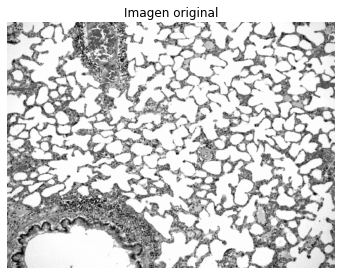

In [10]:
# Cargo y grafico la imagen original
uploaded = files.upload()
keys_list = list(uploaded)
key = keys_list[0]
img = np.array(Image.open(BytesIO(uploaded[key])).convert('L'))
fig, ax = plt.subplots()
fig.tight_layout()
ax.title.set_text('Imagen original')
ax.imshow(img, cmap='gray')
ax.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden', width='max_content'), max=1.0, s…

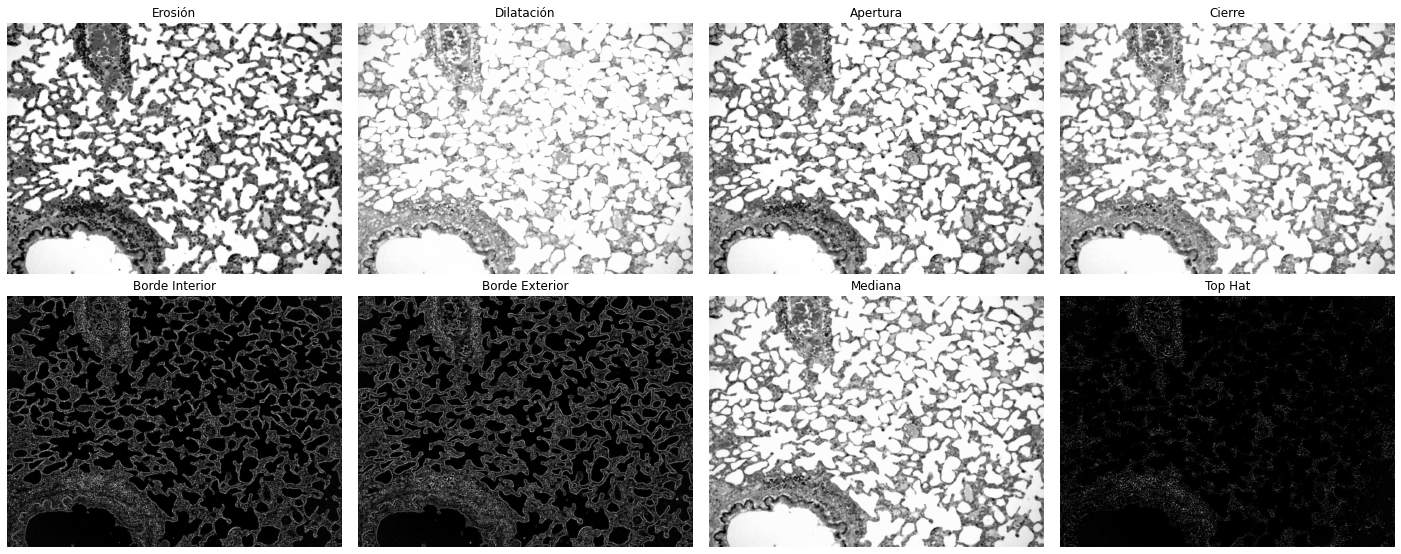

In [ ]:
# Grafico en una misma figura el resultado de todos lo filtros
progress_bar = widgets.FloatProgress(
    value=0,
    min=0,
    max=1,
    bar_style='info',
    style={'bar_color': 'green'},
    orientation='horizontal',
    layout=widgets.Layout(width='max_content',
                            visibility = 'hidden')
)
display(progress_bar)

filters =["Erosión",
          "Dilatación",
          "Apertura",
          "Cierre",
          "Borde Interior",
          "Borde Exterior",
          "Mediana",
          "Top Hat"]

input = img
options = {'image type':'Figura clara/fondo oscuro', 'subtraction mode':'Promediada'}

fig, axs = plt.subplots(2,4,figsize=(20,8))
fig.tight_layout()
axs = axs.ravel()
for i in range(8):
    progress_bar.layout.visibility = 'visible'
    progress_bar.value = i/21
    progress_bar.description = str(int(100 * i/21)) + ' %'

    filter = filters[i]
    output = apply_filter(input, filter, options)
    axs[i].title.set_text(filters[i])
    axs[i].imshow(output, 'gray')
    axs[i].axis('off')

progress_bar.layout.visibility = 'hidden'

axs = axs.reshape(2,4)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

La imagen utilizada es una imagen microscópica de un pulmón de rata, donde las partes blancas corresponden a los alveolos y bronquios.

* Al aplicar erosión las partes oscuras de la imagen avanzan por sobre las partes blancas. 

* Lo contrario sucede al aplicar dilatación, donde se ve que la imagen en general es más clara y las manchas correspondientes a los alveolos se expandieron cerrando el espacio entre ellas.

* Al aplicar apertura debería verse que se borran las regiones blancas más delgadas, pero en la imagen particular que estoy usando no enceuntro algún lugar donde se pueda ver el efecto.

* Al aplicar el filtro de cierre se ve que algunas regiones blancas que se encontraban apenas separadas en la imagen original se enceuntran unidas en la imagen resultante.

* Los filtros de borde generan una imagen mayormente negra, iluminando solamente los píxeles correspondientes a la periferia de los alveolos y bronquios. El filtro de borde interior muestra los píxeles "perdidos" por las partes blancas al aplicar erosión, y el de borde exterior resalta los píxeles "ganados" al aplicar dilatación.

* El resultado de aplicar el filtro de mediana es que se redujeron los detalles más finos y aleatorios que aparecen en las zonas oscuras de la imagen original.

* Finalmente, con el filtro top hat se observa cómo se conservan las partes de la imagen que son pequeñas y más luminosas que su entorno. Se conservan las pequeñas manchas que existen en las regiones oscuras que separan alveolos y bronquios.
